## Import Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from gensim.models import Word2Vec

from sklearn.externals.joblib import parallel_backend

import warnings
warnings.filterwarnings('ignore')
global_start = datetime.datetime.now()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exploratory Data Analysis

### Read The Data

In [3]:
data = pd.read_csv('KickStarter2018_v2.csv')
data.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,id,is_starrable,launched_at,name,pledged,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,cat_id,cat_name,cat_parent,cat_parent_id,cat_link,creator_id,creator_name,creater_registered,loc_id,loc_name,loc_state,loc_country,loc_type,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1.000000,1000.0,1145008426,False,2016-06-04,Glass Christmas Trees & Glass Cross,205.0,glass-christmas-trees-and-glass-cross,https://www.kickstarter.com/discover/categorie...,False,False,failed,2016-06-21,1.000000,205.000000,domestic,347,Glass,crafts,26,http://www.kickstarter.com/discover/categories...,661261267,Mark & Julie Glocke,False,2508897,Turtle Lake,WI,US,Town,https://www.kickstarter.com/discover/places/tu...,North America,https://ksr-ugc.imgix.net/assets/012/621/061/7...,2543897,2543897,https://www.kickstarter.com/projects/coldglass...,17,2016,6,4
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1.000000,2000.0,1687733153,False,2018-10-30,Socks of Speed and Socks of Elvenkind,6061.0,socks-of-speed-and-socks-of-elvenkind,https://www.kickstarter.com/discover/categorie...,True,False,successful,2018-11-15,1.000000,6061.000000,international,34,Tabletop Games,games,12,http://www.kickstarter.com/discover/categories...,497057119,Andy,False,2449378,Menasha,WI,US,Town,https://www.kickstarter.com/discover/places/me...,North America,https://ksr-ugc.imgix.net/assets/023/068/417/2...,3498932,3498932,https://www.kickstarter.com/projects/497057119...,16,2018,10,30
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1.000000,4400.0,1608693208,False,2015-07-07,The Complete Homilies of Blessed Oscar Romero:...,800.0,the-complete-homilies-of-blessed-oscar-romero-...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2015-08-16,1.000000,800.000000,domestic,327,Translations,publishing,18,http://www.kickstarter.com/discover/categories...,267701790,Convivium Press,False,2450022,Miami,FL,US,Town,https://www.kickstarter.com/discover/places/mi...,North America,https://ksr-ugc.imgix.net/assets/012/171/280/2...,1965582,1965582,https://www.kickstarter.com/projects/convivium...,40,2015,7,7
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1.000000,50000.0,66308869,False,2017-05-22,Prodeus: The Future of Work & Learning,1484.0,prodeus-social-network-learning-community-micr...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2017-06-21,1.000000,1484.000000,domestic,342,Web,technology,16,http://www.kickstarter.com/discover/categories...,973039847,James Harr,False,12589335,Brooklyn,NY,US,County,https://www.kickstarter.com/discover/places/br...,North America,https://ksr-ugc.imgix.net/assets/016/544/145/e...,2988723,2988723,https://www.kickstarter.com/projects/973039847...,30,2017,5,22
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...",1066,2018-12-11,EUR,€,USD,2019-02-15,1.133688,700.0,654590050,False,2019-01-11,Dungeon Corp LTD.: The Adventures of Bob and Tim.,941.0,dungeon-corp-ltd-the-adventures-of-bob-and-tim,https://www.kickstarter.com/discover/categorie...,False,True,live,2019-01-11,1.155864,1087.667629,domestic,250,Comic Books,comics,3,http://www.kickstarter.com/discover/categories...,496847178,Eternalverse,False,777341,Vigo,Galicia,ES,Town,https://www.kickstarter.com/discover/places/vi...,Europe,https://ksr-ugc.imgix.net/assets/023/542/956/0...,3533340,3533340,https://www.kickstarter.com/projects/eternalve...,35,2019,1,11


### Number of rows and columns

In [4]:
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))

Number of rows : 223394
Number of columns : 47


### Column names

In [5]:
data.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at', 'currency', 'currency_symbol', 'current_currency', 'deadline', 'fx_rate', 'goal', 'id', 'is_starrable', 'launched_at', 'name', 'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type', 'cat_id', 'cat_name', 'cat_parent', 'cat_parent_id', 'cat_link', 'creator_id', 'creator_name', 'creater_registered', 'loc_id', 'loc_name', 'loc_state', 'loc_country', 'loc_type', 'loc_url', 'continent', 'photo_url', 'profile_id', 'project_id', 'project_url', 'campaign_length', 'year', 'month', 'day'], dtype='object')

### Check for Duplicates

In [6]:
print(data.shape[0] - data.drop_duplicates().shape[0])

0


### Explore The Distribution of 'State'

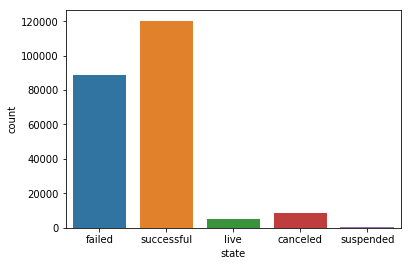

In [7]:
sns.countplot(data['state'])

### Only keeping rows with state as 'successful' or 'failed'

In [8]:
data = data[(data['state']=='failed') | (data['state']=='successful')]
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))
print('\nDistribution of Class Label:')
print(data['state'].value_counts(normalize=True))

Number of rows : 208994
Number of columns : 47

Distribution of Class Label:
successful    0.57549
failed        0.42451
Name: state, dtype: float64


## Feature Extraction

In [9]:
data = data[['deadline', 'goal',
             'launched_at','staff_pick', 'loc_country', 'cat_name', 'cat_parent', 'blurb','state']]

In [11]:
data['launched_at'] = pd.to_datetime(data['launched_at'])
data['deadline'] = pd.to_datetime(data['deadline'])
data['campaign_length'] = (data['deadline'] - data['launched_at']).dt.days
data['blurb_length'] = data['blurb'].apply(lambda x: len(x.split()))
data = pd.get_dummies(data, columns=['loc_country','cat_name', 'cat_parent'])
data.drop(columns=['launched_at','deadline','blurb'], inplace=True)

In [12]:
y = data['state']
X = data.drop(columns='state')
X = pd.DataFrame(np.array(X.values,dtype=np.float64),columns=X.columns)

In [14]:
y

0             failed
1         successful
2             failed
3             failed
5         successful
6         successful
7         successful
8         successful
9             failed
10            failed
11        successful
13        successful
14        successful
15        successful
16        successful
17        successful
18        successful
19        successful
20            failed
21            failed
22        successful
24        successful
25            failed
26            failed
27        successful
29            failed
30        successful
31            failed
32            failed
33            failed
34        successful
35            failed
36            failed
37            failed
38            failed
39            failed
40            failed
41        successful
42        successful
43        successful
46        successful
47            failed
48        successful
49        successful
50        successful
52            failed
53            failed
54           

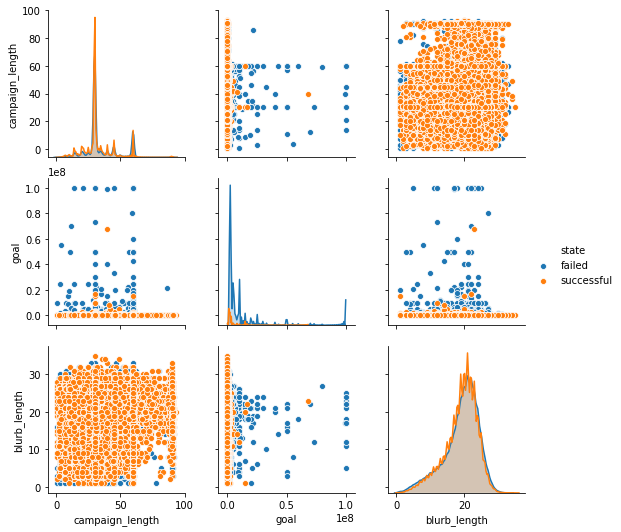

In [11]:
sns.pairplot(data, hue='state', vars=['campaign_length', 'goal', 'blurb_length'])

In [15]:
del data

## Modelling

### Train-Test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, stratify=y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(146295, 380)
(62699, 380)


## Logistic regression + L1 regularization

### Cross-validation 

In [17]:
def cross_val(reg):
    
    start = datetime.datetime.now()
    
    # Create a LR object
    clf = LogisticRegression(class_weight='balanced',penalty=reg, n_jobs=-1)
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['C'] = [0.001, 0.01, 0.1, 0.5, 1, 10, 100]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='f1_micro', cv=2, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    # Plot Hyperparameters v/s AUC score for both train and test data
    params = param_dict['C']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    
    # ****** Code for plotting **********
    plt.figure(figsize=(12,6))
    plt.plot(params, test_scores, '-o', label='Test Scores')
    plt.plot(params, train_scores, '-o', label='Train Scores')
    plt.xlabel('C values', fontsize=13)
    plt.ylabel('micro_f1 score', fontsize=13)
    plt.title('Hyperparameter v/s Micro_f1 Score', fontsize=16)
    plt.grid('on')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nMicro_f1 score of the best model using cross-validation : {}'.format(model.best_score_))
    
    weights = model.best_estimator_.fit(X_train, y_train).coef_[0]
    
    
    positive_weights = weights.argsort()[::-1]
    negative_weights = weights.argsort()
    
    cols = X_train.columns
    
    print('\nTop successful class words :',np.take(cols, positive_weights[:10]))
    print('\nTop failed class words :',np.take(cols, negative_weights[:10]))

    if reg == 'l1':
        sparsity = 1 - (np.count_nonzero(weights) / weights.size)
        print('\nsparsity = {}'.format(sparsity))
    
    return model.best_estimator_

### Predictions on Test Data

In [18]:
def make_predictions(clf):
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    y_scores = clf.predict_proba(X_test)
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\Micro f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='micro')))
    print('\Micro AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='micro')))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  1.1min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  1.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.1min remaining:   37.0s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.1min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.2min finished


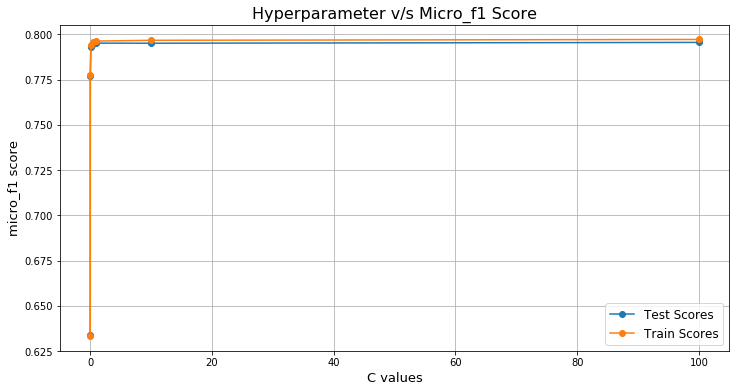


Time taken for cross-validation : 0:01:12.051709

Best model found using cross-validation : LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Micro_f1 score of the best model using cross-validation : 0.7955159096346424

Top successful class words : Index(['cat_name_Video Games', 'cat_name_Product Design', 'cat_name_Comics', 'cat_name_Technology', 'cat_name_Tabletop Games', 'cat_name_Documentary', 'cat_name_Rock', 'cat_name_Shorts', 'cat_name_Art', 'cat_name_Indie Rock'], dtype='object')

Top failed class words : Index(['loc_country_PF', 'loc_country_IR', 'loc_country_LS', 'loc_country_ZW', 'loc_country_WS', 'loc_country_MT', 'loc_country_BY', 'loc_country_AM', 'loc_country_QA', 'loc_country_BW'], dtype='object')

sparsity = 0.047368421052631615


In [19]:
clf =  cross_val('l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7977958181151215
\Micro f1-score on test data : 0.7977958181151215
\Micro AUC score on test data : 0.8962202426983021

              precision    recall  f1-score   support

      failed       0.70      0.91      0.79     26616
  successful       0.92      0.71      0.80     36083

   micro avg       0.80      0.80      0.80     62699
   macro avg       0.81      0.81      0.80     62699
weighted avg       0.82      0.80      0.80     62699





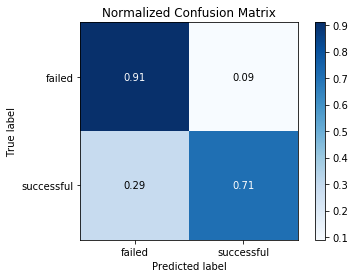

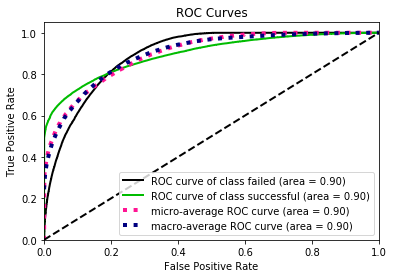

In [22]:
make_predictions(clf)